**Lab: Source Localization for EEG**

Electroencephalography is useful for understanding brain activity. This lab covers using LASSO regression on real EEG dataset to determine brain region that is active under auditory stimulus

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

Loading Data:

In [ ]:
fn_src ='https://drive.google.com/uc?export=download&id=1RzQpKONOcXSMxH2ZzOI4iVMiTgD6ttSl'
fn_dst ='eeg_dat.p'

import os
from six.moves import urllib

if os.path.isfile(fn_dst):
    print('File %s is already downloaded' % fn_dst)
else:        
    print('Fetching file %s [53MB].  This may take a minute..' % fn_dst)
    urllib.request.urlretrieve(fn_src, fn_dst)
    print('File %s downloaded' % fn_dst)

Fetching file eeg_dat.p [53MB].  This may take a minute..
File eeg_dat.p downloaded


In [ ]:
import pickle
fn = 'eeg_dat.p'
with open(fn, 'rb') as fp:
    [X,Y] = pickle.load(fp)

In [ ]:
print(X.shape, Y.shape)

(305, 22494) (305, 85)


In [ ]:
nt = Y.shape[1]
ncur = X.shape[1]
nchan = X.shape[0]
print("nt = {}\nncur = {}\nnchan = {}".format(nt,ncur,nchan))

nt = 85
ncur = 22494
nchan = 305


**Ridge regression**

In [ ]:
Xtr, Xts, Ytr, Yts = train_test_split(X,Y,test_size=0.33)

print(Xtr.shape, Xts.shape, Ytr.shape, Yts.shape)

(204, 22494) (101, 22494) (204, 85) (101, 85)


Using the Ridge regression object in sklearn to fit the model on the training data. Using regularization, alpha=1

In [ ]:
ridge = Ridge(alpha=1)
ridge.fit(Xtr, Ytr)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

Predicting the values Y on both the training and test data and obtaining R^2 on both

In [ ]:
yhat1_ridge = ridge.predict(Xtr)
rsq_tr_ridge = r2_score(Ytr, yhat1_ridge)
print("Training R^2 = {}".format(rsq_tr_ridge))

Training R^2 = 0.6050288623180984


In [ ]:
yhat2_ridge = ridge.predict(Xts)
rsq_ts_ridge = r2_score(Yts, yhat2_ridge)
print('Test R^2 = {}'.format(rsq_ts_ridge))

Test R^2 = 0.20023365122441125


Using cross validation to measure test R^2 for 20 alpha values logarithmically spaced as shown below.

In [ ]:
alphas = np.logspace(-2,2,20)
nalpha = len(alphas)
rsq_alphas = np.zeros(nalpha)

for i, alpha in enumerate(alphas):

        ridge2 = Ridge(alpha=alpha)
        ridge2.fit(Xtr, Ytr)
        yhat = ridge2.predict(Xts)
        rsq_alphas[i] = r2_score(Yts, yhat)
        
imax = np.argmax(rsq_alphas)
max_alpha = alphas[imax]
rsq_max = rsq_alphas[imax]
print("Alpha corresponding to max_rsq = {} and max_rsq = {}".format(max_alpha, rsq_max)) 

Alpha corresponding to max_rsq = 0.4832930238571752 and max_rsq = 0.21190016865819158


Plotting test R^2 v/s alpha

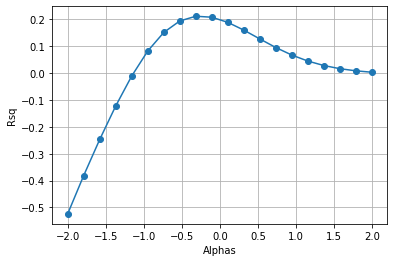

In [ ]:
plt.plot(np.log10(alphas), rsq_alphas, 'o-')
plt.xlabel('Alphas')
plt.ylabel('Rsq')
plt.grid()

In the upcoming section, we do the following,
Find the optimal regularization alpha from the cross-validation

*   Re-fit the model at the optimal alpha
*   Get the current matrix W from the coefficients in the linear model. These are stored in regr.coef_.
*   For each current j compute Wrms[j] =  sqrt( sum_k W[j,k]**2 ) which is root mean squared current.

In [ ]:
ridge3 = Ridge(alpha=max_alpha)
ridge3.fit(Xtr, Ytr)
yhat1 = ridge3.predict(Xts)
W = np.transpose(ridge3.coef_)  
Wrms = np.zeros(W.shape[1])
for j in range(0, W.shape[1] ):
  mean = np.mean(W[j,:]**2)
  Wrms[j] = np.sqrt(mean) 
print(Wrms)

[0.02831705 0.01087404 0.01386463 0.02215743 0.01132104 0.01264801
 0.02472875 0.01203856 0.0180649  0.0204966  0.01377284 0.01361986
 0.02151659 0.01280125 0.01762379 0.01755707 0.01062668 0.0099059
 0.02173811 0.01171533 0.01734261 0.02017884 0.00904791 0.01048397
 0.02004811 0.00878168 0.0121178  0.01789789 0.01159712 0.01638428
 0.01956279 0.01168523 0.01657237 0.01770061 0.00776549 0.01875134
 0.02238616 0.00795802 0.01764179 0.01426092 0.00979543 0.00928867
 0.01832808 0.01015096 0.01157477 0.01783078 0.00812979 0.01060527
 0.01934898 0.00940543 0.01310781 0.01708848 0.00811505 0.01242612
 0.01545047 0.00776341 0.01215876 0.01635104 0.01344822 0.0169906
 0.01845649 0.01337874 0.01780659 0.01796418 0.01227358 0.01904483
 0.01812236 0.01332885 0.01078959 0.01522599 0.0081634  0.01108716
 0.01312402 0.00936942 0.00951729 0.01567158 0.00964478 0.01515108
 0.01242031 0.01026849 0.01439295 0.01200217 0.00730464 0.01459276
 0.01592193]


This shows us that the vector Wrms isn not sparse.

**LASSO Regression**


Re-fitting the training data using the Lasso model with alpha=1e-3. Also setting max_iter=100 and tol=0.01.

In [ ]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

alpha = 1e-3

reg = Lasso(alpha=alpha,max_iter=100,tol=0.01)
reg.fit(Xtr, Ytr)
yhat = reg.predict(Xts)

Testing the model on the test data and measure the R^2 value

In [ ]:
rsq_lasso = r2_score(Yts, yhat)
print('Test R^2= %f' % rsq_lasso)

Test R^2= 0.178579


Searching for the optimal alpha

In [ ]:
alphas = np.logspace(-3,-4,5)
nalpha = len(alphas)
rsq = np.zeros(nalpha)
temp = []
for i, alpha in enumerate(alphas):

        reg = Lasso(alpha=alpha,max_iter=100,tol=0.01)
        reg.fit(Xtr, Ytr)
        temp.append(reg.coef_)
        yhat1 = reg.predict(Xts)
        rsq[i] = r2_score(Yts, yhat1)
        
imax = np.argmax(rsq)
max_alpha = alphas[imax]
rsq_max = rsq[imax]
W_lasso = temp[imax]
print("Alpha corresponding to max_rsq = {} and max_rsq = {}".format(max_alpha, rsq_max)) 


Alpha corresponding to max_rsq = 0.00017782794100389227 and max_rsq = 0.3475318593334792


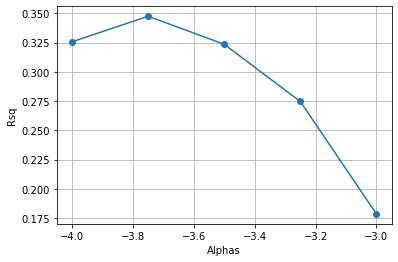

In [ ]:
plt.plot(np.log10(alphas), rsq, 'o-')
plt.xlabel('Alphas')
plt.ylabel('Rsq')
plt.grid()

In [ ]:
W2 = np.transpose(W_lasso)  
Wrms2 = np.zeros(W2.shape[1])
for j in range(0, W2.shape[1] ):
  mean2 = np.mean(W2[j,:]**2)
  Wrms2[j] = np.sqrt(mean2) 
print(Wrms)

[0.02831705 0.01087404 0.01386463 0.02215743 0.01132104 0.01264801
 0.02472875 0.01203856 0.0180649  0.0204966  0.01377284 0.01361986
 0.02151659 0.01280125 0.01762379 0.01755707 0.01062668 0.0099059
 0.02173811 0.01171533 0.01734261 0.02017884 0.00904791 0.01048397
 0.02004811 0.00878168 0.0121178  0.01789789 0.01159712 0.01638428
 0.01956279 0.01168523 0.01657237 0.01770061 0.00776549 0.01875134
 0.02238616 0.00795802 0.01764179 0.01426092 0.00979543 0.00928867
 0.01832808 0.01015096 0.01157477 0.01783078 0.00812979 0.01060527
 0.01934898 0.00940543 0.01310781 0.01708848 0.00811505 0.01242612
 0.01545047 0.00776341 0.01215876 0.01635104 0.01344822 0.0169906
 0.01845649 0.01337874 0.01780659 0.01796418 0.01227358 0.01904483
 0.01812236 0.01332885 0.01078959 0.01522599 0.0081634  0.01108716
 0.01312402 0.00936942 0.00951729 0.01567158 0.00964478 0.01515108
 0.01242031 0.01026849 0.01439295 0.01200217 0.00730464 0.01459276
 0.01592193]


This shows that current matrix W for the optimal alpha is much sparser as compared to Ridge Regression case